# Classify Waste Products Using Transfer Learning

In [36]:
# Import dependencies
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

In [12]:
import os
import subprocess
import zipfile

# Define dataset URL and paths
url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/4yIRGlIpNfKEGJYMhZV52g/fruits-360-original-size.zip"
local_zip = "fruits-360-original-size.zip"
extract_dir = "fruits-360-original-size"

def download_dataset(url, output_file):
    """Download the dataset using wget in quiet mode."""
    print("Downloading the dataset...")
    subprocess.run(["wget", "-q", "-O", output_file, url], check=True)  # Add `-q` for quiet mode
    print("Download completed.")

def extract_zip_in_chunks(zip_file, extract_to, batch_size=2000):
    """
    Extract a large zip file in chunks to avoid memory bottlenecks.
    Processes a specified number of files (batch_size) at a time.
    """
    print("Extracting the dataset in chunks...")
    os.makedirs(extract_to, exist_ok=True)  # Ensure the extraction directory exists

    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        files = zip_ref.namelist()  # List all files in the archive
        total_files = len(files)

        for i in range(0, total_files, batch_size):
            batch = files[i:i+batch_size]
            for file in batch:
                zip_ref.extract(file, extract_to)  # Extract each file in the batch
            print(f"Extracted {min(i+batch_size, total_files)} of {total_files} files...")

    print(f"Dataset successfully extracted to '{extract_to}'.")

# Main script execution
if __name__ == "__main__":
    # Download the dataset if not already downloaded
    if not os.path.exists(local_zip):
        download_dataset(url, local_zip)
    else:
        print("Dataset already downloaded.")

    # Extract the dataset if not already extracted
    if not os.path.exists(extract_dir):
        extract_zip_in_chunks(local_zip, extract_dir)
    else:
        print("Dataset already extracted.")

    # Optional cleanup of the zip file
    if os.path.exists(local_zip):
        os.remove(local_zip)
        print(f"Cleaned up zip file: {local_zip}")

Download completed.
Extracting the dataset in chunks...
Extracted 2000 of 12481 files...
Extracted 4000 of 12481 files...
Extracted 6000 of 12481 files...
Extracted 8000 of 12481 files...
Extracted 10000 of 12481 files...
Extracted 12000 of 12481 files...
Extracted 12481 of 12481 files...
Dataset successfully extracted to 'fruits-360-original-size'.
Cleaned up zip file: fruits-360-original-size.zip


In [2]:
# Task 1: Print Tensorflow version
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.18.0


In [3]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.data_adapters.py_dataset_adapter")
warnings.filterwarnings("ignore", category=UserWarning, module="keras.src.trainers.epoch_iterator")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress all warnings and info messages

In [13]:
# Define path dataset base
base_dir = "fruits-360-original-size/fruits-360-original-size/"
train_dir = os.path.join(base_dir, "Training")
valid_dir = os.path.join(base_dir, "Validation")
test_dir = os.path.join(base_dir, "Test")

# Normalization and Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Generator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode="categorical",
)

validation_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode="categorical",
)

# Task 2: Create test_generator
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(64, 64),
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
)

Found 6231 images belonging to 24 classes.
Found 3114 images belonging to 24 classes.
Found 3110 images belonging to 24 classes.


In [31]:
# Base pre-trained
base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(64, 64, 3))
base_model.trainable = False

extract_feat_model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(train_generator.num_classes, activation='softmax'),
])

# Task 4: Summary the model
extract_feat_model.summary()

/tmp/ipykernel_6131/3487442794.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=(64, 64, 3))


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 2, 2, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 24)             │         6,168 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,592,088 (9.89 MB)

 Trainable params: 334,104 (1.27 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [32]:
# Task 5: Compile the model
extract_feat_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [33]:
history_extract = extract_feat_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,
)

Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 56s 265ms/step - accuracy: 0.6393 - loss: 1.2304 - val_accuracy: 0.8866 - val_loss: 0.3583
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 52s 266ms/step - accuracy: 0.8877 - loss: 0.3540 - val_accuracy: 0.9133 - val_loss: 0.2243
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 51s 261ms/step - accuracy: 0.9071 - loss: 0.2534 - val_accuracy: 0.9550 - val_loss: 0.1402
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 50s 256ms/step - accuracy: 0.9343 - loss: 0.1883 - val_accuracy: 0.9377 - val_loss: 0.1902
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 50s 259ms/step - accuracy: 0.9339 - loss: 0.1800 - val_accuracy: 0.9461 - val_loss: 0.1547


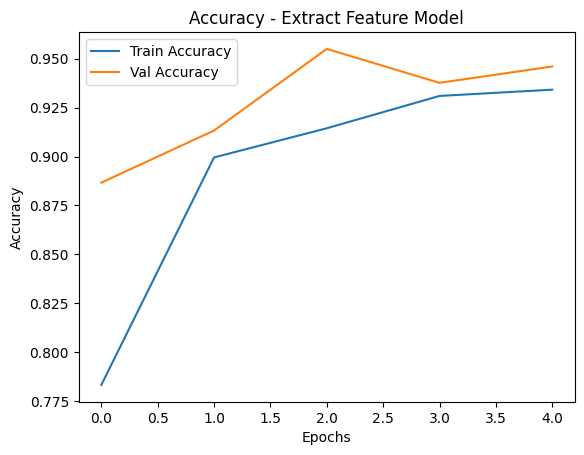

In [34]:
# Task 6: Plot Train vs Val accuracy
plt.plot(history_extract.history['accuracy'], label='Train Accuracy')
plt.plot(history_extract.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy - Extract Feature Model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [35]:
# Fine-tuning
base_model.trainable = True
steps_per_epoch = 50
validation_steps = 25

num_layers = len(base_model.layers)
print(f"The base model has {num_layers} layers.")

# Freeze BatchNorm layers to speed up fine-tuning
for layer in base_model.layers:
    if isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = False

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

extract_feat_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

history_finetune = extract_feat_model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    steps_per_epoch=steps_per_epoch,  # Reduced steps per epoch
    validation_steps=validation_steps,  # Reduced validation steps
    callbacks=[lr_scheduler, early_stopping]
)

The base model has 154 layers.
Epoch 1/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 322ms/step - accuracy: 0.9451 - loss: 0.1513 - val_accuracy: 0.9837 - val_loss: 0.0626 - learning_rate: 1.0000e-05
Epoch 2/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 15s 313ms/step - accuracy: 0.9557 - loss: 0.1195 - val_accuracy: 0.9750 - val_loss: 0.0888 - learning_rate: 1.0000e-05
Epoch 3/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 291ms/step - accuracy: 0.9647 - loss: 0.0979 - val_accuracy: 0.9775 - val_loss: 0.0584 - learning_rate: 1.0000e-05
Epoch 4/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 254ms/step - accuracy: 0.9831 - loss: 0.0535 - val_accuracy: 0.9812 - val_loss: 0.0464 - learning_rate: 1.0000e-05
Epoch 5/5
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 318ms/step - accuracy: 0.9740 - loss: 0.0632 - val_accuracy: 0.9550 - val_loss: 0.1115 - learning_rate: 1.0000e-05


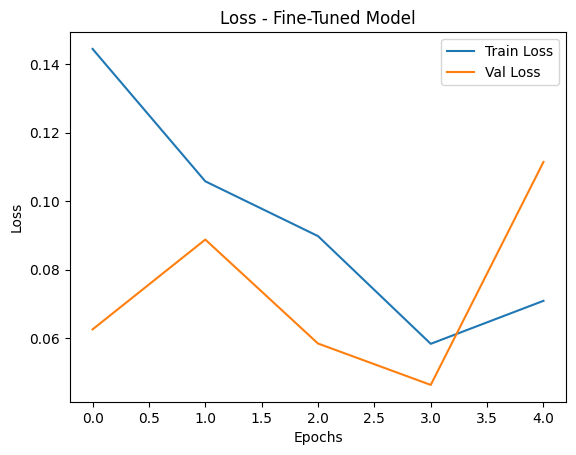

In [37]:
# Task 7: Plot Loss - Fine Tune
plt.plot(history_finetune.history['loss'], label='Train Loss')
plt.plot(history_finetune.history['val_loss'], label='Val Loss')
plt.title("Loss - Fine-Tuned Model")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

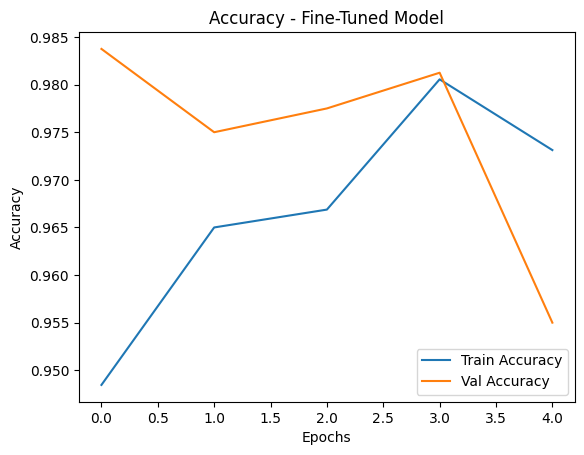

In [38]:
# Task 8: Plot Accuracy - Fine Tune
plt.plot(history_finetune.history['accuracy'], label='Train Accuracy')
plt.plot(history_finetune.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy - Fine-Tuned Model")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step


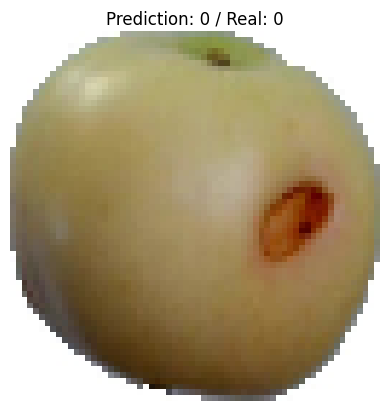

In [39]:
# Task 9: Show images with extract features model
index_to_plot = 1
img, label = test_generator[index_to_plot]
pred = extract_feat_model.predict(img)

plt.imshow(img[0])
plt.title(f"Prediction: {np.argmax(pred[0])} / Real: {np.argmax(label[0])}")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


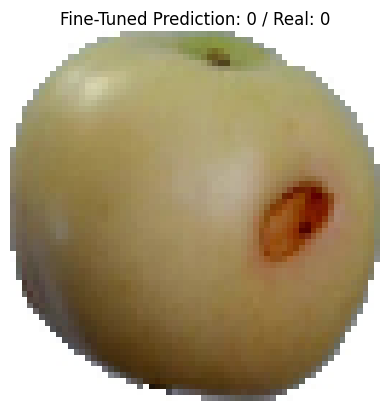

In [40]:
# Task 10: Show image with fine-tuned model
img, label = test_generator[index_to_plot]
pred = extract_feat_model.predict(img)

plt.imshow(img[0])
plt.title(f"Fine-Tuned Prediction: {np.argmax(pred[0])} / Real: {np.argmax(label[0])}")
plt.axis('off')
plt.show()

Class Index Mapping: {'apple_6': 0, 'apple_braeburn_1': 1, 'apple_crimson_snow_1': 2, 'apple_golden_1': 3, 'apple_golden_2': 4, 'apple_golden_3': 5, 'apple_granny_smith_1': 6, 'apple_hit_1': 7, 'apple_pink_lady_1': 8, 'apple_red_1': 9, 'apple_red_2': 10, 'apple_red_3': 11, 'apple_red_delicios_1': 12, 'apple_red_yellow_1': 13, 'apple_rotten_1': 14, 'cabbage_white_1': 15, 'carrot_1': 16, 'cucumber_1': 17, 'cucumber_3': 18, 'eggplant_violet_1': 19, 'pear_1': 20, 'pear_3': 21, 'zucchini_1': 22, 'zucchini_dark_1': 23}
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


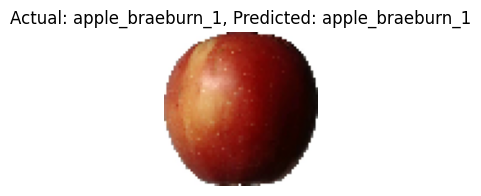

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


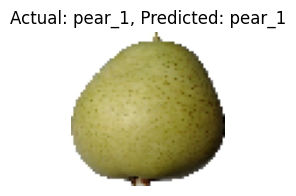

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


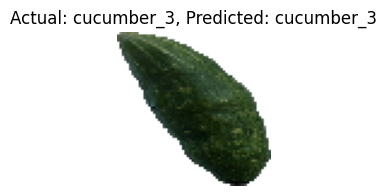

In [41]:
import os
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt

# Initialize counters for actual and predicted classes
actual_count = Counter()
predicted_count = Counter()

# Function to get class name from predicted index
def get_class_name_from_index(predicted_index, class_index_mapping):
    """Convert predicted index to class name."""
    for class_name, index in class_index_mapping.items():
        if index == predicted_index:
            return class_name
    return "Unknown"  # Default if index is not found

# Define the function for visualization
def visualize_prediction_with_actual(img_path, class_index_mapping):
    # Extract the true label dynamically from the directory structure
    class_name = os.path.basename(os.path.dirname(img_path))  # Extract folder name (class)

    # Load and preprocess the image
    img = load_img(img_path, target_size=(64, 64))
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict the class
    prediction = extract_feat_model.predict(img_array)
    predicted_index = np.argmax(prediction, axis=-1)[0]
    predicted_class_name = get_class_name_from_index(predicted_index, class_index_mapping)

    # Update the counters
    actual_count[class_name] += 1
    predicted_count[predicted_class_name] += 1

    # Visualize the image with predictions
    plt.figure(figsize=(2, 2), dpi=100)
    plt.imshow(img)
    plt.title(f"Actual: {class_name}, Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

# Retrieve class index mapping from the training generator
class_index_mapping = train_generator.class_indices
print("Class Index Mapping:", class_index_mapping)  # Debugging: Check the mapping

# Define a list of image paths without hardcoded labels
sample_images = [
    'fruits-360-original-size/fruits-360-original-size/Test/apple_braeburn_1/r0_11.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/pear_1/r0_103.jpg',
    'fruits-360-original-size/fruits-360-original-size/Test/cucumber_3/r0_103.jpg',
]

# Run the predictions and visualization
for img_path in sample_images:
    visualize_prediction_with_actual(img_path, class_index_mapping)

### Author

Mateus Andrade